In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
from torchvision import datasets, transforms

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Files already downloaded and verified


In [11]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


TypeError: ignored

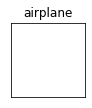

In [12]:
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = Net()


numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [22]:
import time as time

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    t0 = time.time()
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('Epoch {}, Training loss {}'.format(
                epoch,
                loss_train / len(train_loader)))  # <10>
    print('Training complete. Duration: {} seconds'.format(time.time() - t0))

In [24]:

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(n_epochs = 300,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,
              )

Epoch 1, Training loss 2.0312202696300226
Epoch 10, Training loss 1.1885616627648055
Epoch 20, Training loss 1.001973374344199
Epoch 30, Training loss 0.9097980158713163
Epoch 40, Training loss 0.8574916188369321
Epoch 50, Training loss 0.816632344213593
Epoch 60, Training loss 0.7857970139178474
Epoch 70, Training loss 0.7593458372613658
Epoch 80, Training loss 0.7393098195343066
Epoch 90, Training loss 0.7180828632753523
Epoch 100, Training loss 0.6980723047347934
Epoch 110, Training loss 0.6845232587107613
Epoch 120, Training loss 0.6690925087998895
Epoch 130, Training loss 0.6576699135858385
Epoch 140, Training loss 0.6458601145945546
Epoch 150, Training loss 0.6341780620386533
Epoch 160, Training loss 0.6232720463705794
Epoch 170, Training loss 0.6146823388078938
Epoch 180, Training loss 0.6057670880156709
Epoch 190, Training loss 0.5977806396344129
Epoch 200, Training loss 0.5887591545005588
Epoch 210, Training loss 0.5833555029328826
Epoch 220, Training loss 0.5749608964642601
E

In [25]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.81
Accuracy val: 0.61


In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()


numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(20002, [432, 16, 1152, 8, 16384, 32, 512, 16, 1440, 10])

In [28]:

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(n_epochs = 300,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,
              )

Epoch 1, Training loss 2.2127388034330306
Epoch 10, Training loss 1.230107887626609
Epoch 20, Training loss 1.007948851875027
Epoch 30, Training loss 0.9142784512866183
Epoch 40, Training loss 0.8562858129858666
Epoch 50, Training loss 0.8175941762107107
Epoch 60, Training loss 0.7855528943678912
Epoch 70, Training loss 0.7606634534609592
Epoch 80, Training loss 0.7389265573238168
Epoch 90, Training loss 0.7205028081565257
Epoch 100, Training loss 0.7028167358673442
Epoch 110, Training loss 0.6868532514938003
Epoch 120, Training loss 0.6728102394077174
Epoch 130, Training loss 0.659112051700997
Epoch 140, Training loss 0.6479829210988091
Epoch 150, Training loss 0.6362349213008076
Epoch 160, Training loss 0.6228339519647076
Epoch 170, Training loss 0.6125680166284752
Epoch 180, Training loss 0.6047735781697057
Epoch 190, Training loss 0.595726834386206
Epoch 200, Training loss 0.5872907387592908
Epoch 210, Training loss 0.5801765033427406
Epoch 220, Training loss 0.5723637919444258
Epo

In [29]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.82
Accuracy val: 0.62
